# Matrices de covariance en trading **Rates** — Notebook pédagogique

Ce notebook couvre **6 usages concrets** des matrices de covariance en trading **Rates** :  
1. Variance d’un portefeuille (via $\Sigma$)  
2. Hedging (hedge ratio à partir de la covariance)  
3. Optimisation de portefeuille (Markowitz)  
4. VaR paramétrique (variance–covariance)  
5. PCA (analyse en composantes principales) pour facteurs **Level / Slope / Curvature**  
6. Simulation Monte Carlo multi-instruments corrélée

Chaque section contient : rappel théorique, code minimal reproductible et interprétation.


## Préparation: données synthétiques Rates

On génère des **variations journalières** (en bps) pour 4 instruments : `Swap_2Y`, `Swap_5Y`, `Swap_10Y`, `Bond_30Y`.
On impose une structure de corrélation "réaliste" (forte corrélation croisée).

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)  # reproductibilité

instruments = ["Swap_2Y", "Swap_5Y", "Swap_10Y", "Bond_30Y"]
d = len(instruments)
n = 500  # 500 jours

# Vols journalières en bps (exemples)
sigmas_bps = np.array([4.0, 5.0, 6.0, 7.0])  # 2Y < 5Y < 10Y < 30Y

# Corrélation cible (forte, décroissante avec l'écart de maturité)
rho = np.array([
    [1.00, 0.95, 0.90, 0.85],
    [0.95, 1.00, 0.93, 0.88],
    [0.90, 0.93, 1.00, 0.92],
    [0.85, 0.88, 0.92, 1.00]
])

# Construction de la covariance en bps^2
Sigma_bps2 = np.outer(sigmas_bps, sigmas_bps) * rho

# Cholesky pour simuler des variations corrélées
L = np.linalg.cholesky(Sigma_bps2)

Z = np.random.randn(n, d)
dR_bps = Z @ L.T  # variations journalières en bps

df = pd.DataFrame(dR_bps, columns=instruments)
df.head()

,Swap_2Y,Swap_5Y,Swap_10Y,Bond_30Y
0,1.986857,2.143527,3.896543,8.085164
1,-0.936613,-1.477775,1.844694,3.316771
2,-1.877898,-1.382932,-2.764634,-4.055633
3,0.967849,-1.837787,-5.215277,-6.484126
4,-4.051324,-4.320329,-6.998124,-11.067829


---
## 1) Variance d’un portefeuille $ w^\top \Sigma w $

**Rappel**
- $ \Sigma $ = matrice de covariance des rendements/variations (ici en bps).  
- Pour un vecteur de poids $w$ (ex: proportion de DV01 allouée), la **variance du portefeuille** est :  
$
\mathrm{Var}(P) = w^\top \Sigma \, w.
$

**Idée** : si les actifs sont fortement corrélés, la diversification est limitée. Si les corrélations sont faibles ou négatives, la variance de portefeuille baisse.


In [23]:
# Matrice de covariance empirique (échantillon) en bps^2
Sigma_hat = df.cov()  # ddof=1 par défaut

# Exemple de poids (DV01-normalisés ou notional relatifs) — somme = 1
w = np.array([0.25, 0.25, 0.25, 0.25])

# Variance du portefeuille (bps^2)
var_P = float(w @ Sigma_hat.values @ w.T)

# Volatilité (écart-type) du portefeuille (bps)
vol_P = np.sqrt(var_P)

print("Variance portefeuille (bps^2):", round(var_P, 2))
print("Vol portefeuille (bps):", round(vol_P, 2))

# Visualisation simple: barres des contributions marginales approximatives
# Contribution ~ w_i * (Sigma w)_i
contrib = w * (Sigma_hat.values @ w)
for name, c in zip(instruments, contrib):
    print(f"Contribution approx de {name}: {c:.2f} (bps^2)")

Variance portefeuille (bps^2): 23.82
Vol portefeuille (bps): 4.88
Contribution approx de Swap_2Y: 4.23 (bps^2)
Contribution approx de Swap_5Y: 5.44 (bps^2)
Contribution approx de Swap_10Y: 6.51 (bps^2)
Contribution approx de Bond_30Y: 7.65 (bps^2)


**Interprétation**  
- La variance $w^\top \Sigma w$ agrège les risques **et** les **co-mouvements**.  
- Les contributions indiquent quelles jambes dominent le risque de portefeuille.  
- En Rates, on peut remplacer $w$ par un **vecteur de sensibilités DV01** pour obtenir directement une variance de **PnL** en monnaie (après conversion bps → PnL via DV01).

---
## 2) Hedging via la covariance (hedge ratio)

**Rappel (pour 2 actifs $X=5Y$, $Y=10Y$)**:  
$
h^\star = \frac{\mathrm{Cov}(X, Y)}{\mathrm{Var}(Y)}
$
… est le **beta/hedge ratio** qui **minimise la variance** de $X - h Y$.

On généralise souvent avec une régression OLS de $X$ sur $Y$.


Hedge ratio 5Y ~ h*10Y: 0.773
Var(5Y): 21.45  | Var(residuel): 3.44


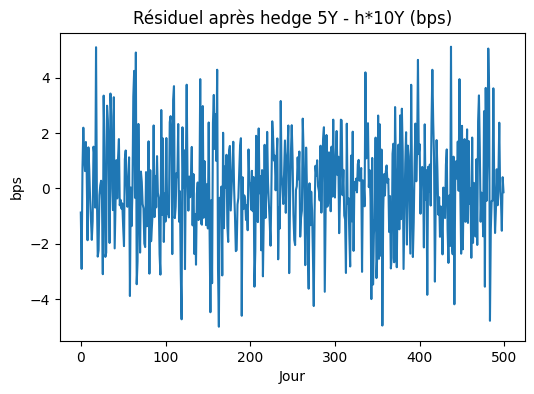

In [24]:
x = df["Swap_5Y"].to_numpy()
y = df["Swap_10Y"].to_numpy()

cov_xy = np.cov(x, y, ddof=1)[0, 1]
var_y = np.var(y, ddof=1)

h_opt = cov_xy / var_y  # hedge ratio X ~ h*Y
residual = x - h_opt * y

print("Hedge ratio 5Y ~ h*10Y:", round(h_opt, 3))
print("Var(5Y):", np.var(x, ddof=1).round(2), " | Var(residuel):", np.var(residual, ddof=1).round(2))

plt.figure(figsize=(6,4))
plt.plot(residual)
plt.title("Résiduel après hedge 5Y - h*10Y (bps)")
plt.xlabel("Jour")
plt.ylabel("bps")
plt.show()

**Interprétation**  
- Le **résiduel** représente le **spread** non expliqué par le 10Y.  
- Une variance résiduelle **nettement plus faible** valide l’efficacité du hedge.  
- En pratique Rates, on calcule des beta-hedges entre points de courbe pour obtenir un book **neutre** vis-à-vis d’un facteur commun (ex: *level*).

---
## 3) Optimisation de portefeuille (Markowitz)

**Rappel** (sans contrainte, pour intuition) :  
$
w^\star \propto \Sigma^{-1} \mu
$
où $\mu$ = rendements espérés (ici, on prend une moyenne historique des variations).
On montrera aussi la **frontière moyenne–variance** en balayant un paramètre de risque $\lambda$.

Minimum Variance Portfolio:
  w* = {'Swap_2Y': np.float64(1.774), 'Swap_5Y': np.float64(-0.415), 'Swap_10Y': np.float64(-0.16), 'Bond_30Y': np.float64(-0.199)}
  mean=-0.045 bps/j, vol=3.279 bps/j

Tangency-like Portfolio (heuristique):
  w* = {'Swap_2Y': np.float64(-0.524), 'Swap_5Y': np.float64(0.237), 'Swap_10Y': np.float64(0.046), 'Bond_30Y': np.float64(0.193)}
  mean=0.104 bps/j, vol=1.101 bps/j


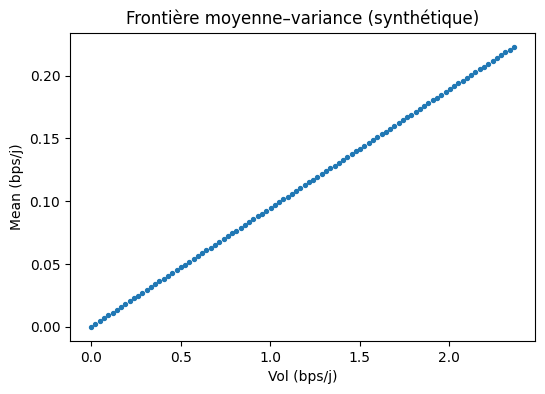

In [25]:
mu = df.mean().values  # "rendement" moyen (bps/j)
Sigma = Sigma_hat.values
d = len(mu)

# Pénalité de régularisation (shrinkage ridge) pour stabiliser l'inversion si besoin
ridge = 1e-6 * np.eye(d)
Sigma_inv = np.linalg.inv(Sigma + ridge)

w_mvp = Sigma_inv @ np.ones(d)  # minimum variance sous somme libre (non normalisé)
w_mvp = w_mvp / w_mvp.sum()

# Portefeuille de tangence (simplement proportionnel à Sigma^{-1} mu)
w_tan = Sigma_inv @ mu
if w_tan.sum() != 0:
    w_tan = w_tan / abs(w_tan).sum()

def port_stats(w):
    m = float(w @ mu)
    v = float(w @ Sigma @ w)
    return m, np.sqrt(v)

m_mvp, s_mvp = port_stats(w_mvp)
m_tan, s_tan = port_stats(w_tan)

print("Minimum Variance Portfolio:")
print("  w* =", dict(zip(instruments, np.round(w_mvp,3))))
print(f"  mean={m_mvp:.3f} bps/j, vol={s_mvp:.3f} bps/j")

print("\nTangency-like Portfolio (heuristique):")
print("  w* =", dict(zip(instruments, np.round(w_tan,3))))
print(f"  mean={m_tan:.3f} bps/j, vol={s_tan:.3f} bps/j")

# Tracé de la frontière moyenne-variance (balayage quadratique)
lambdas = np.linspace(0, 50, 100)
means = []
vols = []
for lam in lambdas:
    # Solution fermée de min_w w' Σ w - λ μ' w  =>  (2Σ)w = λ μ
    w_l = np.linalg.solve(2*(Sigma+ridge), lam*mu)
    m, s = port_stats(w_l)
    means.append(m); vols.append(s)

plt.figure(figsize=(6,4))
plt.scatter(vols, means, s=8)
plt.xlabel("Vol (bps/j)")
plt.ylabel("Mean (bps/j)")
plt.title("Frontière moyenne–variance (synthétique)")
plt.show()

**Interprétation**  
- Le portefeuille **minimum-variance** minimise le risque sans viser de performance.  
- Le portefeuille de **tangence** illustre l’utilisation de $\Sigma^{-1}\mu$.  
- La frontière montre le compromis risque–rendement pour différents appétits au risque $\lambda$.  
- En Rates, on peut travailler en **DV01** pour optimiser un **risque PnL** plutôt que des bps de taux.

---
## 4) VaR paramétrique (variance–covariance)

**Rappel** : si les PnL journaliers sont approximativement **gaussiens** avec variance $\sigma_P^2$, alors la **VaR** (à $\alpha=99\%$) vaut :
$
\mathrm{VaR}_{99\%} \approx z_{0.99}\,\sigma_P
$
où $z_{0.99}\approx 2.33$.

Ici, on passe de variations de taux (en bps) à un **PnL** via un vecteur **DV01** (monétaire par bp).

Sigma(PnL) ~ 428.24 k$ / jour
VaR 99% (1j, paramétrique) ~ 997.79 k$


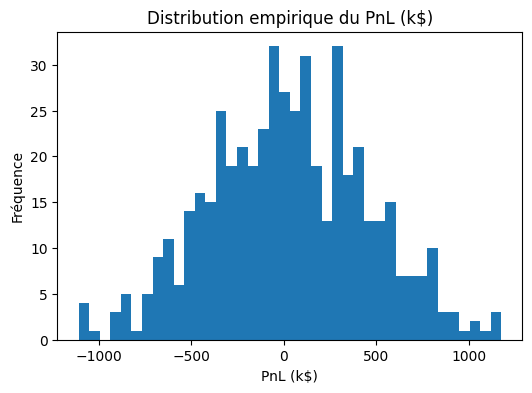

In [26]:
# DV01 en k$ / bp (exemple)
DV01 = np.array([12.0, 18.0, 22.0, 30.0])  # k$ par bp

# PnL quotidien ≈ DV01 · dR (en k$)
pnl = (df.values * DV01).sum(axis=1)  # somme des contributions

sigma_pnl = pnl.std(ddof=1)
z_99 = 2.33
VaR_99 = z_99 * sigma_pnl

print(f"Sigma(PnL) ~ {sigma_pnl:.2f} k$ / jour")
print(f"VaR 99% (1j, paramétrique) ~ {VaR_99:.2f} k$")

plt.figure(figsize=(6,4))
plt.hist(pnl, bins=40)
plt.title("Distribution empirique du PnL (k$)")
plt.xlabel("PnL (k$)")
plt.ylabel("Fréquence")
plt.show()

**Interprétation**  
- En supposant une loi normale, on obtient une VaR **fermée**.  
- Sensible aux **corrélations** (via $\Sigma$) et à la **taille DV01**.  
- En pratique, on compare à des approches **historique** et **Monte Carlo** pour robustesse.

---
## 5) PCA (Analyse en composantes principales)

**Rappel** : la PCA diagonalise $\Sigma$ :  
$
\Sigma = Q \Lambda Q^\top
$
où les colonnes de $Q$ sont les **facteurs** (composantes), et $\Lambda$ les variances associées.

Dans les taux, on obtient souvent :  
- **Facteur 1** ≈ *Level* (déplacement parallèle),  
- **Facteur 2** ≈ *Slope* (2Y vs 30Y),  
- **Facteur 3** ≈ *Curvature* (ventre vs ailes).

Variance expliquée par composante:
  PC1: 91.8%
  PC2: 5.2%
  PC3: 2.1%
  PC4: 0.9%


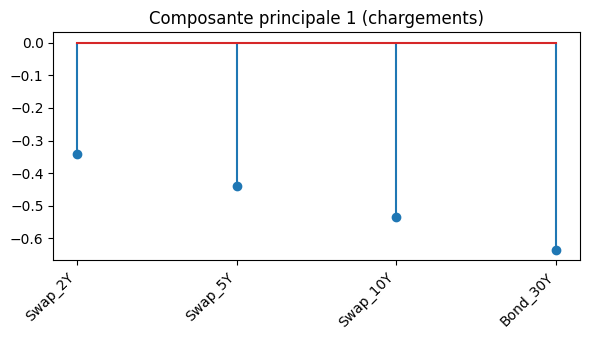

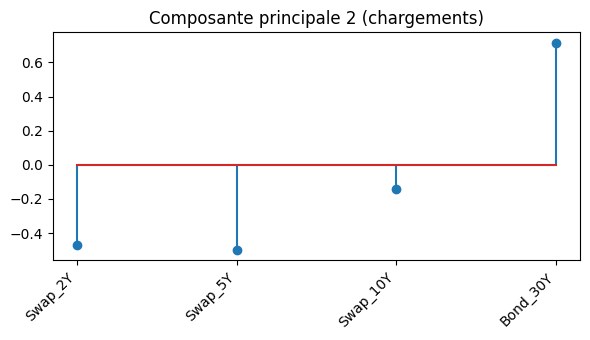

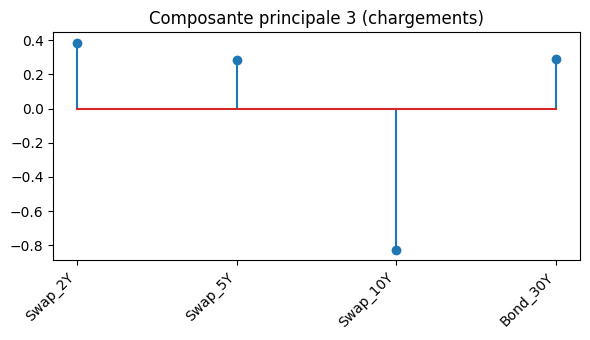

In [27]:
# Décomposition propre (symétrique) sur Sigma_hat
eigvals, eigvecs = np.linalg.eigh(Sigma_hat.values)  # valeurs triées croissantes
# On renverse pour décroissant
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

explained_var_ratio = eigvals / eigvals.sum()

print("Variance expliquée par composante:")
for i, r in enumerate(explained_var_ratio[:d], 1):
    print(f"  PC{i}: {r*100:.1f}%")

# Visualisation des 3 premiers vecteurs propres
for k in range(min(3,d)):
    plt.figure(figsize=(6,3.5))
    markerline, stemlines, baseline = plt.stem(range(d), eigvecs[:, k])
    plt.xticks(range(d), instruments, rotation=45, ha="right")
    plt.title(f"Composante principale {k+1} (chargements)")
    plt.tight_layout()
    plt.show()

**Interprétation**  
- **PC1** concentre souvent l’essentiel de la variance → facteur **Level**.  
- **PC2** oppose les maturités courtes et longues → **Slope**.  
- **PC3** accentue le milieu de courbe → **Curvature**.  
- Ces facteurs simplifient le **hedging** et la **construction de spreads**.

---
## 6) Simulation Monte Carlo multi-instruments corrélée

On simule $N$ scénarios journaliers corrélés via Cholesky de $\Sigma$, puis on calcule la distribution du **PnL** d’un portefeuille DV01.


MC: quantile 1% du PnL ~ -1071.40 k$


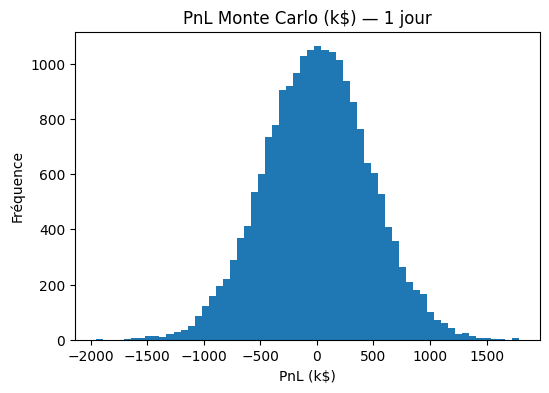

In [28]:
N = 20000
Z = np.random.randn(N, d)
scen = Z @ L.T  # mêmes corrélations/vols que précédemment (bps)

# PnL simulé (k$)
pnl_mc = (scen * DV01).sum(axis=1)

p01 = np.percentile(pnl_mc, 1)  # 1% quantile (perte)
print(f"MC: quantile 1% du PnL ~ {p01:.2f} k$")

plt.figure(figsize=(6,4))
plt.hist(pnl_mc, bins=60)
plt.title("PnL Monte Carlo (k$) — 1 jour")
plt.xlabel("PnL (k$)")
plt.ylabel("Fréquence")
plt.show()

**Interprétation**  
- La simulation **reproduit** les dépendances de $\Sigma$.  
- On peut intégrer des non-linéarités (convexité) et des distributions non gaussiennes.  
- Compare la VaR MC avec la VaR paramétrique et historique pour un **diagnostic de risque**.